## load precomputed models

In [1]:
using DataFrames
using JLD
@load "precomputedmodels.jld"

INFO: Recompiling stale cache file /Users/jakub/.julia/lib/v0.6/FileIO.ji for module FileIO.
INFO: Recompiling stale cache file /Users/jakub/.julia/lib/v0.6/JLD.ji for module JLD.


3-element Array{Symbol,1}:
 :data
 :m1  
 :m2  

## load data

In [3]:
using CSV
using DataFrames
smut = CSV.read("SMutList.txt", delim="\t")
data0 = smut[1,:]
data0[:Mut] = "WT"
data0[:ham] = 0
ns = names(smut)
for (n1,n2) in zip(ns[2:7], ns[8:13])
    data0[n1] = data0[n2]
end
smut[:ham] = 1
smut = vcat(data0, smut)
delete!(smut, [:Pos; ns[8:13]])
dmut = CSV.read("DMutList.txt", delim="\t")
delete!(dmut, ns[8:13])
dmut[:ham] = 2
datafr = vcat(smut, dmut)
# note that positions in :Mut are off by 1; you should +1 these positions

,Mut,DNA,NoT,Sel1,Sel2,Sel3,SelAll,ham
1,WT,1759616,152778,1049016,974519,1018284,3041819,0
2,T15R,106367,8325,64293,59468,60914,184675,1
3,T15S,71248,5010,23657,22454,23344,69455,1
4,T15P,90794,6864,22261,21502,22568,66331,1
5,T15Q,40611,2999,16887,15810,16184,48881,1
6,T15V,57504,4494,24635,24151,24590,73376,1
7,T15W,39584,2666,6899,6725,7139,20763,1
8,T15Y,15737,987,3480,3461,3667,10608,1
9,T15C,18196,1621,5829,5622,5546,16997,1
10,T15A,38128,2678,9568,9606,9909,29083,1


In [2]:
using DataFrames
using RCall

R"""
library(ggplot2)
library(cowplot)
library(dplyr)
theme_set(theme_cowplot(11))
options(device = function(filename=getOption('rcalljl_filename'),...) png(filename, width=800, height=800, ...))
""";

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [1]:
function prepdata(df, seqname, kind, wt, c0n, c1n; delim = '-')
    n = nrow(df)
    I = collect(1:n)
    J = ones(Int64, n)
    j = 2
    aa = Char[' ']
    pos = Int64[0]
    code = Dict{String, Int64}()
    if kind == :listofmuts
        muts = df[seqname]
        for i = 1:n
            if muts[i] != wt
                for k in split(muts[i], delim)
                    if !haskey(code, k)
                        code[k] = j
                        push!(aa, k[end])
                        push!(pos, parse(k[2:end-1]))
                        j += 1
                    end
                    push!(J, code[k])
                    push!(I, i)
                end
            end
        end
    elseif kind == :sequence
        seq = df[seqname]
        ns = length(wt)
        for i = 1:n
            for p = 1:ns
				a = seq[i][p]
	            if a != wt[p]
                    k = string(wt[p], p, a)
                    if !haskey(code, k)
                        code[k] = j
                        push!(aa, a)
                        push!(pos, p)
                        j += 1
                    end
                    push!(J, code[k])
                    push!(I, i)
                end
            end
        end
    end
    x = sparse(I, J, 1.0)
    g = trues(size(x,2))
    g[1] = false
    ham = ceil.(Int64, vec(sum(x,2))-1)
	
	c0 = collect(Missings.skipmissing(df[c0n]))
    c1 = collect(Missings.skipmissing(df[c1n]))
	wti = find(df[seqname] .== wt)[1]
    f = log.((c1+.5)./(c0+.5)*(c0[wti]+0.5)/(c1[wti]+.5))
    fv = (c0+c1+1)./((c0+.5).*(c1+.5))
    fv[df[seqname] .!= wt] = fv[df[seqname] .!= wt] + fv[wti]
    Dict(:x => x, :c0 => c0, :c1 => c1, :code => code, :fv => fv, :wt => wt,
                :ham=> ham, :f =>f, :pos => pos, :aa => aa)
end

prepdata (generic function with 1 method)

In [75]:
data = prepdata(datafr, :Mut, :listofmuts, "WT", :DNA, :SelAll)

Dict{Symbol,Any} with 10 entries:
  :ham  => [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
  :wt   => "WT"
  :fv   => [8.97056e-7, 1.57133e-5, 2.93301e-5, 2.69867e-5, 4.59783e-5, 3.19153…
  :f    => [0.0, 0.00434018, -0.572847, -0.861294, -0.362012, -0.303619, -1.192…
  :pos  => [0, 15, 15, 15, 15, 15, 15, 15, 15, 15  …  43, 43, 43, 43, 43, 43, 4…
  :aa   => [' ', 'R', 'S', 'P', 'Q', 'V', 'W', 'Y', 'C', 'A'  …  'F', 'A', 'N',…
  :code => Dict("G40L"=>148,"E26K"=>415,"T15D"=>13,"K9M"=>516,"D35H"=>64,"T48P"…
  :c0   => [1759616, 106367, 71248, 90794, 40611, 57504, 39584, 15737, 18196, 3…
  :c1   => [3041819, 184675, 69455, 66331, 48881, 73376, 20763, 10608, 16997, 2…
  :x    => …

## two state model

In [44]:
using NLopt

function energymodel(data, kind, maxe = Inf; kwargs...)
    l = size(data[:x],2)
   
    energies = DataFrame(efi = zeros(l))
    pb0 = 0.01
    if kind == :fold_and_bind
        energies[:ebi] = zeros(l)
    end
    r = 1.0
    mi = Dict(:r => r, :pb0 => pb0, :kind => kind, :data => data,
        :energies => energies, :maxe => maxe)
    energymodel(mi; kwargs...)
end

function energymodel(mi; alg = :LD_MMA, maxit = 1000000, tol = 1e-12,
        fixparameter = nothing, fixparametervalue = 0.0,
        fixparameterindex = 0, normalize = true)
    data = mi[:data]
    kind = mi[:kind]
    x = data[:x]
    c0 = data[:c0]
    c1 = data[:c1]
    n, l = size(x)

    efi = (mi[:energies][:efi])
    r = mi[:r]
    pb0 = mi[:pb0]

    efr = 2:(l+1)
    mem1 = zeros(n)
    mem2 = zeros(n)
    mem3 = zeros(n)
    mem4 = zeros(n)
    mll = zeros(n)
    best = [-Inf]
    prog = nothing
    if kind == :fold_and_bind
        ebr = (l+2):(2l+1)
        ebi = (mi[:energies][:ebi])
        pi = [log(r); efi; ebi; log(pb0)]
        mem6 = zeros(n)
        mem7 = zeros(n)
        opt = Opt(alg, length(pi))
        max_objective!(opt, (p, g) -> fold_and_bind_obj(p, g, 
                n, efr, ebr, x, c0, c1, mem1, mem2, mem3, mem4, mem7,
                mem6, mll, prog, best, normalize))
    elseif kind == :fold
        pi = [log(r); efi; log(pb0)]
        opt = Opt(alg, length(pi))
        max_objective!(opt, (p, g) -> fold_obj(p, g, n, efr, x, c0, c1,
                mem1, mem2, mem3, mem4, mll, prog, best, normalize))
    end    
    
    maxeval!(opt, maxit)
#     xtol_abs!(opt, default_tol)
    ftol_rel!(opt, tol)

    maxe = mi[:maxe]
    lbounds = -maxe*ones(pi)
    lbounds[1] = -Inf
    lbounds[end] = -Inf
    ubounds = maxe*ones(pi)
    ubounds[end] = Inf
    ubounds[1] = Inf
    if fixparameter == :r
        ifixpar = 1
    elseif fixparameter == :pb0
        ifixpar = length(pi)
    elseif fixparameter == :efi
        ifixpar = efr[fixparameterindex]
    elseif fixparameter == :ebi
        ifixpar = ebr[fixparameterindex]
    end
    if fixparameter != nothing
        lbounds[ifixpar] = fixparametervalue
        ubounds[ifixpar] = fixparametervalue
        pi[ifixpar] = fixparametervalue
    end
    if any(lbounds != -Inf)
        lower_bounds!(opt, lbounds)
    end
    if any(ubounds != Inf)
        upper_bounds!(opt, ubounds)
    end
    (ll, p, ret) =  optimize!(opt, pi)
    if normalize
        ll = ll*n
    end
    if ret != :FTOL_REACHED
        warn("FTOL not reached, $ret")
    end
    
    dout = Dict(:kind => kind, :ll => ll, :pb0 => exp(p[end]), :r => exp(p[1]), 
        :return => ret, :data => data, :maxe=>maxe)
    
    dout[:energies] = DataFrame(pos = data[:pos], aa = data[:aa], efi = p[efr])
    #energies[:efi] = p[efr]
    if kind == :fold_and_bind
        dout[:energies][:ebi] = p[ebr]
    end
    dout[:pred] = predict(dout, x)
    
    return dout
end

function fold_obj(p, g, n, efr, x, c0, c1, ef, dLde,
        dr, dp0, ll, prog, best, normalize)
    r = exp(p[1])
    pb0 = exp(p[end])
    A_mul_B!(ef, x, view(p, efr))

    Threads.@threads for i = 1:n
        exf = exp(ef[i])
        ep = pb0*exf
        r1px = r*(1 + ep)
        nt = c0[i] + c1[i]
        ll[i] = -nt*log(1+exf+r1px) + c0[i]*log1p(exf) + c1[i]*log(r1px)
        temp3 = -nt*r1px/(1+exf+r1px) + c1[i]
        dr[i] = temp3
        temp = temp3*exf/(1+ep)
        dp0[i] = temp*pb0
        dLde[i] = -temp*(1-pb0)/(1+exf)
    end
    g[1] = sum_kbn(dr)
    g[end] = sum_kbn(dp0)
    At_mul_B!(view(g, efr), x, dLde)
    g[2] = sum_kbn(dLde)

    dll = sum_kbn(ll)
    if normalize
        g .= g./n
        dll = dll/n
    end
    
    return dll
end
import StatsBase.predict

function predict(m, x::SparseMatrixCSC{Float64,Int64})
    prediction = DataFrame(ef = x*m[:energies][:efi])
    p0 = m[:pb0]
    ex = exp.(prediction[:ef])
    pwt = exp(m[:energies][:efi][1])
    if m[:kind] == :fold_and_bind
        prediction[:eb] = x*m[:energies][:ebi]
        ex = exp.(prediction[:eb]).*(1+ex)
        pwt = exp(m[:energies][:ebi][1])*(1+pwt)
    end
    p = (1+p0*ex)./(1+ex)
    pwt = (1+p0*pwt)/(1+pwt)
    prediction[:p] = p
    prediction[:f] = log.(p/pwt)
    return prediction
end

using Distributions
function boot(m, kind=:naive; kwargs...)
    mboot = copy(m)
    mboot[:data] = copy(m[:data])
    rp = m[:r]*m[:pred][:p]
    if kind == :thermo
        mboot[:data][:c0] = rand.(Poisson.((m[:data][:c0].+m[:data][:c1])./(1+rp)))
        mboot[:data][:c1] = rand.(Poisson.((m[:data][:c0].+m[:data][:c1])./(1+rp).*rp))
    elseif kind == :naive
        mboot[:data][:c0] = rand.(Poisson.(m[:data][:c0]))
        mboot[:data][:c1] = rand.(Poisson.(m[:data][:c1]))
    end
    energymodel(mboot; kwargs...)
end

function bootsearch(mi, i, tol=1e-4, cb = nothing; kwargs...)
    mdls = []
    mbest = copy(mi)
    mbest[:data] = mi[:data]
    while length(mdls) < i
        mboot = boot(mbest, :naive; kwargs...)
        mboot[:data] = mi[:data]
        m = energymodel(mboot; kwargs...)
        dll = m[:ll]-mbest[:ll]
        if dll > tol
            mbest = m
            mdls = []
        else
            delete!(mboot, :pred)
            push!(mdls, mboot)
        end
        display("delta $dll, i $(length(mdls))")
        if cb != nothing
            cb(mbest)
        end
    end
    mbest[:boot] = mdls
    mbest[:energies_boot] = boot_stat(mbest)
    display("total delta LL $(mbest[:ll]-mi[:ll])")
    return mbest
end


function boot_stat(m)
    pboot = deepcopy(m[:boot][1][:energies])
    for mb in m[:boot][2:end]
        append!(pboot, mb[:energies])
    end
    ci = (d,s) -> DataFrame( 
                            med = median(d[s]), 
                            upper = quantile(d[s], .975), 
                            lower = quantile(d[s], .025))
    #return pboot
    bbs = by(pboot, [:pos, :aa], d -> ci(d, :efi))
    rename!(bbs, :med => :f_med)
    rename!(bbs, :upper => :f_upper)
    rename!(bbs, :lower => :f_lower)
    if m[:kind] == :fold_and_bind
        bbsb = by(pboot, [:pos, :aa], d -> ci(d, :ebi))
        rename!(bbsb, :med => :b_med)
        rename!(bbsb, :upper => :b_upper)
        rename!(bbsb, :lower => :b_lower)
        bbs = join(bbs, bbsb, on = [:pos, :aa])
    end
    bbs = join(m[:energies], bbs, on = [:pos,:aa])
    #bbs = vcat(bbs, stack(m[:energies], [:efi, :ebi]))
    return bbs
end
#energymodel(data, :fold, 15, maxit=10)

boot_stat (generic function with 1 method)

In [ ]:
# warning can take a long time
@time m1 = energymodel(data, :fold, 15)
# this can take even longer
m1 = bootsearch(m1, 100, 1e-4)

### log binding prediction

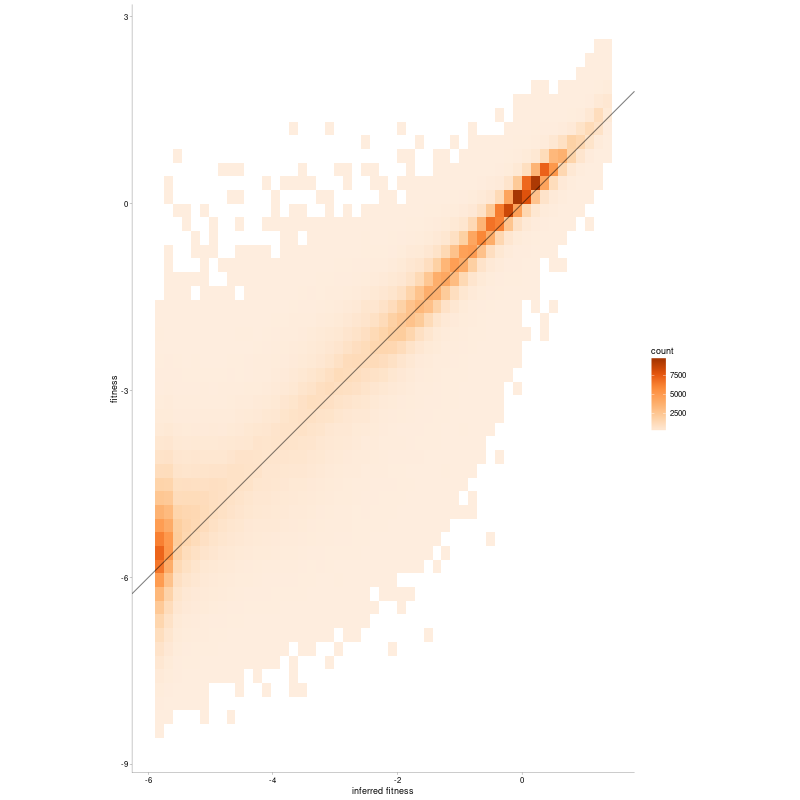

RCall.RObject{RCall.VecSxp}


In [200]:
R"""
plot.yyhat1 = qplot(x=$(m1[:pred][:f]), y=$(m1[:data][:f]), geom="bin2d", bins=50) +
geom_abline(alpha=0.5) + coord_fixed() +
scale_fill_distiller(palette=7, direction=1) +
xlab("inferred fitness") + ylab("fitness")
"""

### folding energy v log binding

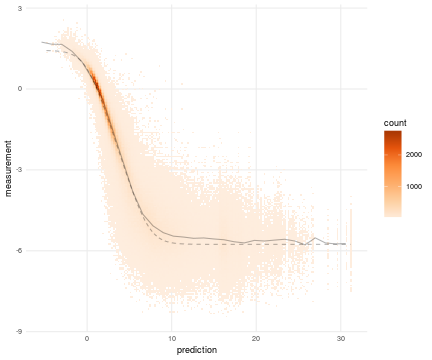

RCall.RObject{RCall.VecSxp}


In [4]:
R"""
qplot(data=$(m1[:pred]), x=ef, y=$(m1[:data][:f]), geom="bin2d", bins=200) +
geom_line(aes(y=f), alpha=0.3, linetype=2) +
scale_fill_distiller(palette=7, direction=1) +
xlab("prediction") + ylab("measurement") +
stat_summary_bin(geom="line", fun.y=median, alpha=0.3)

"""

### delta delta G


	Pearson's product-moment correlation

data:  `#JL`$estab1$efi and `#JL`$estab1$ddg
t = 0.89546, df = 80, p-value = 0.3732
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1199839  0.3099243
sample estimates:
     cor 
0.099617 



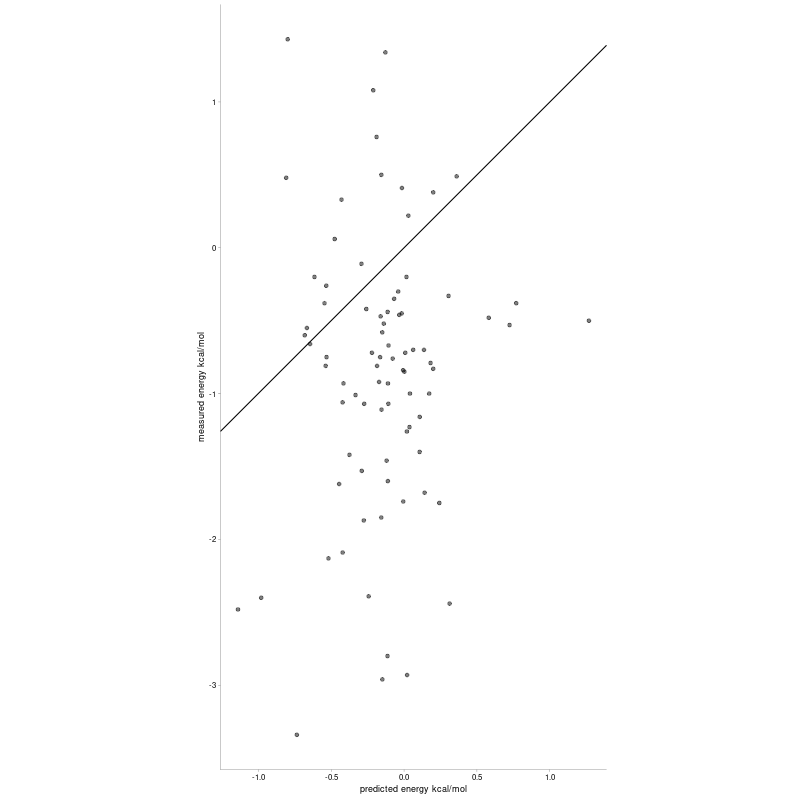

RCall.RObject{RCall.VecSxp}


In [226]:
stab = CSV.read("stabilities.csv")

stab[:pos] = [parse(Int64, match(r"\d+", bn).match) for bn in stab[:mutation]]
stab[:aa] = [match(r"(?<=\d)[A-Z]|\*", bn).match for bn in stab[:mutation]]
estab1 = join(stab, m1[:energies], on = [:pos, :aa], kind = :inner)
for s in [:efi]#, :f_lower, :f_upper]
    estab1[s] = -estab1[s] * 0.001987 * (273+24)
end
R"print(cor.test($estab1$efi, $estab1$ddg))"

R"""
plot.ddg1 = qplot(data=$estab1, x=efi, y=ddg, alpha=I(.5)) +
xlab("predicted energy kcal/mol") +
ylab("measured energy kcal/mol") +
coord_fixed() + geom_abline() #+ geom_errorbarh(aes(xmin=f_lower, xmax=f_upper))
"""


In [227]:
R"""
save_plot("../oneenergy.pdf", plot.ddg1, base_width=3.25)
"""

RCall.RObject{RCall.NilSxp}
NULL


## three state, 2 energy model

In [45]:
function fold_and_bind_obj(p, g, n, efr, ebr, x, c0, c1, ef, eb, 
        dldef, dldeb, dr, dp0, ll, prog, best, normalize)
    efi = view(p, efr)
    ebi = view(p, ebr)
    r = exp(p[1])
    pb0 = exp(p[end])
    A_mul_B!(ef, x, efi)
    A_mul_B!(eb, x, ebi)
    Threads.@threads for i = 1:n
        exfb = exp(ef[i]+eb[i])
        exfbb = exfb + exp(eb[i])
        r1px = r*(1 + pb0*exfbb)
        nt = c0[i] + c1[i]
        ll[i] = -nt*log(1+exfbb+r1px) + c0[i]*log1p(exfbb) + c1[i]*log(r1px)

        rdldr = -nt*r1px/(1+exfbb+r1px) + c1[i]
        dr[i] = rdldr
        dp0[i] = rdldr*exfbb/(1+pb0*exfbb)*pb0
        temp = rdldr*(pb0-1)/(1+pb0*exfbb)/(1+exfbb)
        dldef[i] = exfb*temp
        dldeb[i] = exfbb*temp
    end
    g[1] = sum_kbn(dr)
    g[end] = sum_kbn(dp0)
    gef = view(g, efr)
    At_mul_B!(gef, x, dldef)
    g[efr[1]] = sum_kbn(dldef)
    geb = view(g, ebr)
    At_mul_B!(geb, x, dldeb)
    g[ebr[1]] = sum_kbn(dldeb)
    if normalize
        g .= g./n
        dll = mean(ll)
    else
        dll = sum_kbn(ll)
    end
    return dll
end
energymodel(data, :fold_and_bind, 15, maxit=10)

Dict{Symbol,Any} with 9 entries:
  :data     => Dict{Symbol,Any}(Pair{Symbol,Any}(:f, [0.0, 0.445425, 0.0535051,…
  :kind     => :fold_and_bind
  :return   => :MAXEVAL_REACHED
  :maxe     => 15
  :pred     => 536963×4 DataFrames.DataFrame…
  :energies => 1046×4 DataFrames.DataFrame…
  :ll       => -4.03865e8
  :pb0      => 0.0106101
  :r        => 0.807827

In [9]:
@time m2 = energymodel(data, :fold_and_bind, 15)
# WARNING this can take forever
m2 = bootsearch(m2, 100, 1e-4)

353.789075 seconds (144.71 k allocations: 79.974 MiB, 0.00% gc time)


Dict{Symbol,Any} with 9 entries:
  :data     => Dict{Symbol,Any}(Pair{Symbol,Any}(:ham, [0, 1, 1, 1, 1, 1, 1, 1,…
  :kind     => :fold_and_bind
  :return   => :FTOL_REACHED
  :maxe     => 15
  :pred     => 536963×4 DataFrames.DataFrame…
  :energies => 1046×4 DataFrames.DataFrame…
  :ll       => -2.72728e8
  :pb0      => 0.000705594
  :r        => 8.96743

### log binding prediction

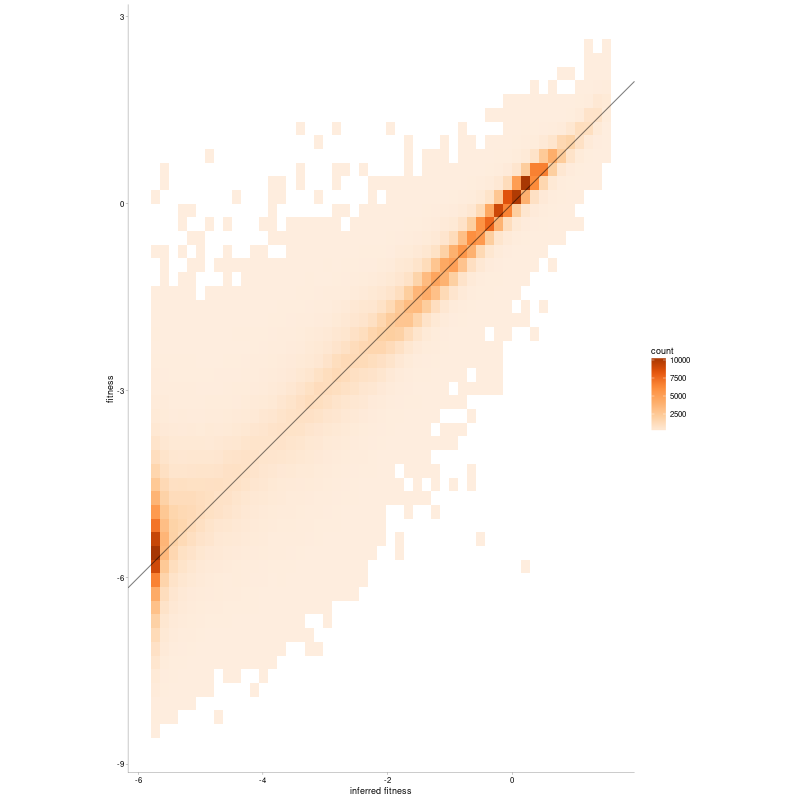

RCall.RObject{RCall.VecSxp}


In [201]:
R"""
plot.yyhat2 = qplot(data=$(m2[:pred]), x=f, y=$(m2[:data][:f]), geom="bin2d", bins=50) +
geom_abline(alpha=0.5) + coord_fixed() +
scale_fill_distiller(palette=7, direction=1) +
xlab("inferred fitness") + ylab("fitness")

"""

In [246]:
R"""
dyyhat = data_frame(`three state`=$(m2[:pred][:f]), `two state`=$(m1[:pred][:f]), f=$(m2[:data][:f])) %>%
    gather("var","val", 1:2)

plot.yyhat2 = qplot(data=dyyhat, x=val, y=f, geom="bin2d", color=..count.., bins=50, facets=var~.) +
geom_abline(alpha=0.5) + coord_fixed() +
scale_fill_distiller(palette=7, direction=1) +
scale_color_distiller(palette=7, direction=1) +
xlab("inferred fitness") + ylab("fitness") + theme(strip.background=element_blank())

save_plot("../yyhat.pdf", plot.yyhat2, base_width=3.25, base_height=5)
"""

RCall.RObject{RCall.NilSxp}
NULL


### delta delta G

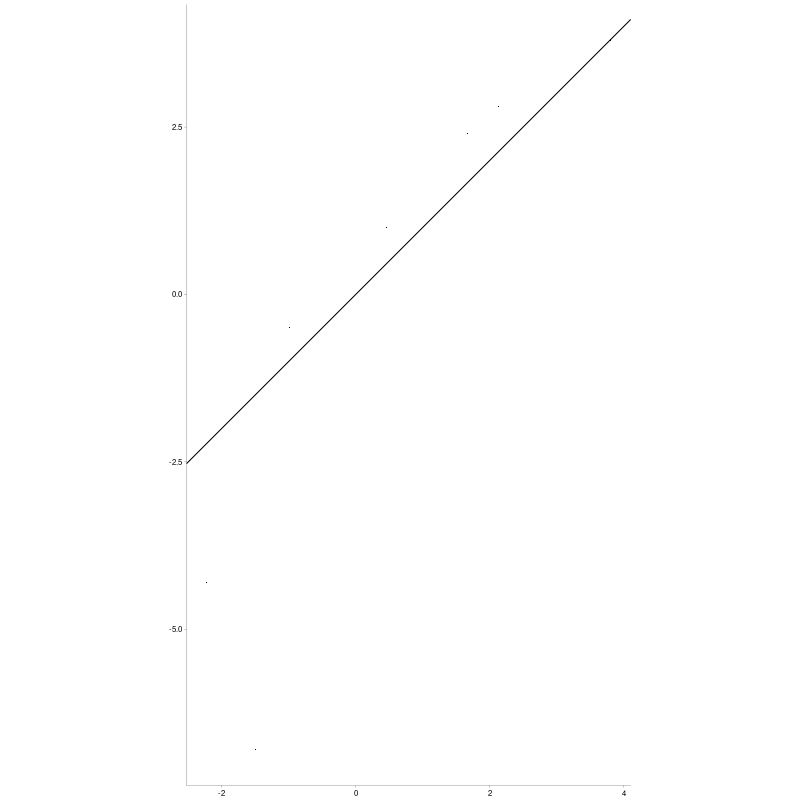

RCall.RObject{RCall.VecSxp}


In [150]:
gf = (pos, aa) -> m2[:energies][:efi][(
        pos.==m2[:energies][:pos]) .&
    (aa.==m2[:energies][:aa])][1]* 0.001987 * (273+24)

estabmm = DataFrame(ddg = -[0.5, -0.1, -1, -2.4, -2.8, -3.8, 4.3, 6.8],
                    efi = [gf(3,"F")+gf(7,"I")+gf(39,"I"),
                            gf(21,"P")+gf(23,"P"),
                            gf(6,"V")+gf(7,"I")+gf(19,"K")+
                            gf(24,"E")+gf(29,"A")+gf(42,"V"),
                            gf(6,"V")+gf(53,"A"),
                            gf(5,"V")+gf(6,"V")+gf(7,"F")+gf(54,"L"),
                            gf(6,"V")+gf(7,"V")+gf(52,"L"),
                            gf(3,"F")+gf(7,"I")+gf(39,"I")+gf(16,"I")+gf(18,"I")+gf(25,"E")+gf(29,"I"),
                            gf(15,"V")+gf(16,"I")+gf(18,"I")+gf(37,"L")])
R"""
plot.ddg2 = qplot(data=$estabmm, x=efi, y=ddg, stroke=0, size=I(.5)) +
    geom_abline() + labs(x=NULL,y=NULL) + coord_fixed() #+
    #theme(panel.border=element_rect(color="black", size=.4, linetype=1))
"""

0.9103834389851837

0.3921822649742794

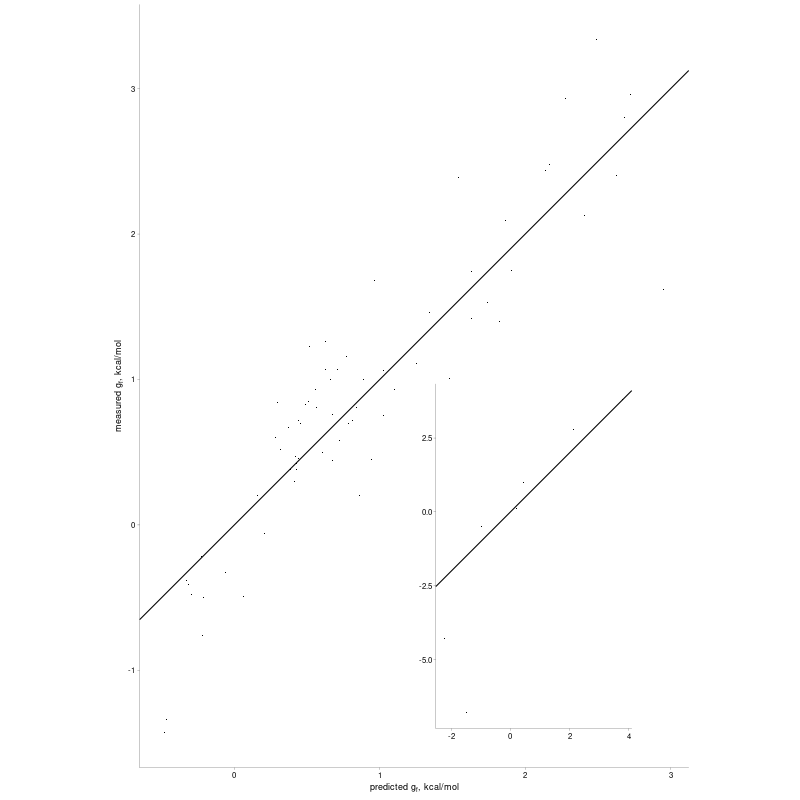

RCall.RObject{RCall.VecSxp}


In [151]:
using CSV
stab = CSV.read("stabilities.csv")

stab[:pos] = [parse(Int64, match(r"\d+", bn).match) for bn in stab[:mutation]]
stab[:aa] = [match(r"(?<=\d)[A-Z]|\*", bn).match for bn in stab[:mutation]]
stab[:ddg] = -stab[:ddg]
estab = join(stab, m2[:energies], on = [:pos, :aa], kind = :inner)
estab[:efi] = estab[:efi] * 0.001987 * (273+24)
display(cor(estab[:efi], estab[:ddg]))
display(sqrt(mean((estab[:efi]-estab[:ddg]).^2)))

R"""
plot.ddg = qplot(data=$estab, x=efi, y=ddg, stroke=0, size=I(.5)) +
xlab(expression(paste("predicted ", g[f], ", kcal/mol"))) +
ylab(expression(paste("measured ", g[f], ", kcal/mol"))) +
coord_fixed() + geom_abline() + 
annotation_custom(grob =  ggplotGrob(plot.ddg2), xmin = .5, xmax = 3.5, ymin = -1.5, ymax = 1)
# geom_point(data=$estabmm, color="red", alpha=.5)
"""


### marginal binding energy

-0.002396688566109839

0.9915143942879366

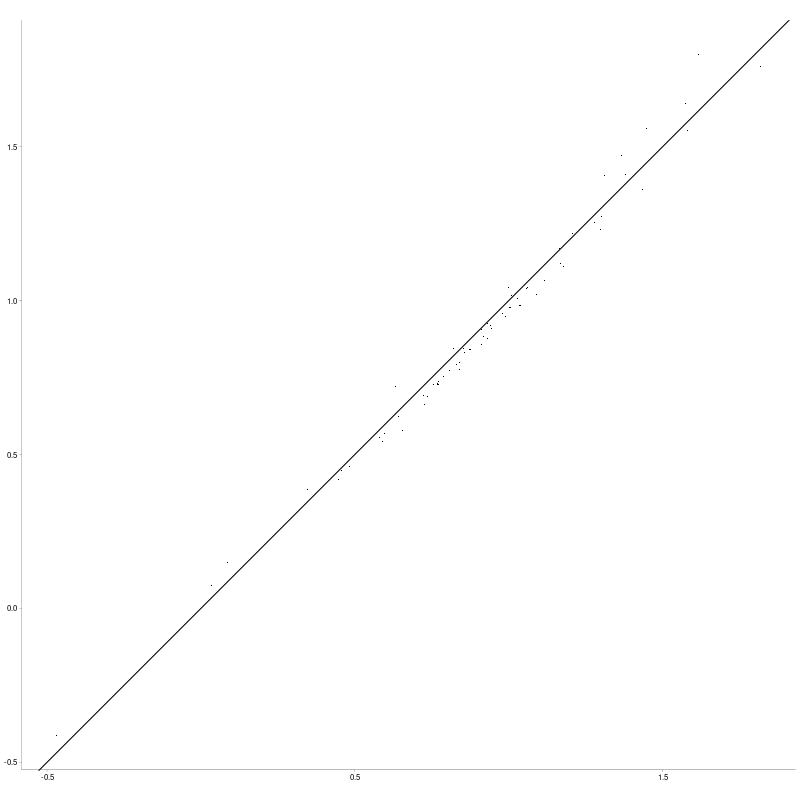

RCall.RObject{RCall.VecSxp}


In [166]:
i = find(data[:ham].==1)
j = map(i -> find(view(data[:x], i, :))[2], i)
pdf = DataFrame(pos = data[:pos][j], aa = data[:aa][j],
        p = data[:c1][i]./data[:c0][i]/m2[:r],
        ef = m2[:pred][:ef][i]* 0.001987 * (273+24), eb = m2[:pred][:eb][i]* 0.001987 * (273+24))
pdf = join(estab, pdf, on = [:pos, :aa], kind=:inner)
pdf[:gbi] = 0.001987 * (273+24)*(log.(1-pdf[:p]).-log.(pdf[:p]-m2[:pb0]))
display(median(.-log1p.(exp.(pdf[:ddg]/0.593+m2[:energies][:efi][1]))))
display(cor(pdf[:gbi],pdf[:eb]))
R"""
plot.ddgb2 = qplot(data=$pdf, x=eb, y=gbi, stroke=0, size=I(.5)) + 
coord_fixed() + geom_abline() + theme(axis.title=element_blank()) + 
    scale_x_continuous(breaks=c(-0.5, 0.5, 1.5))
"""

0.9597446803907379

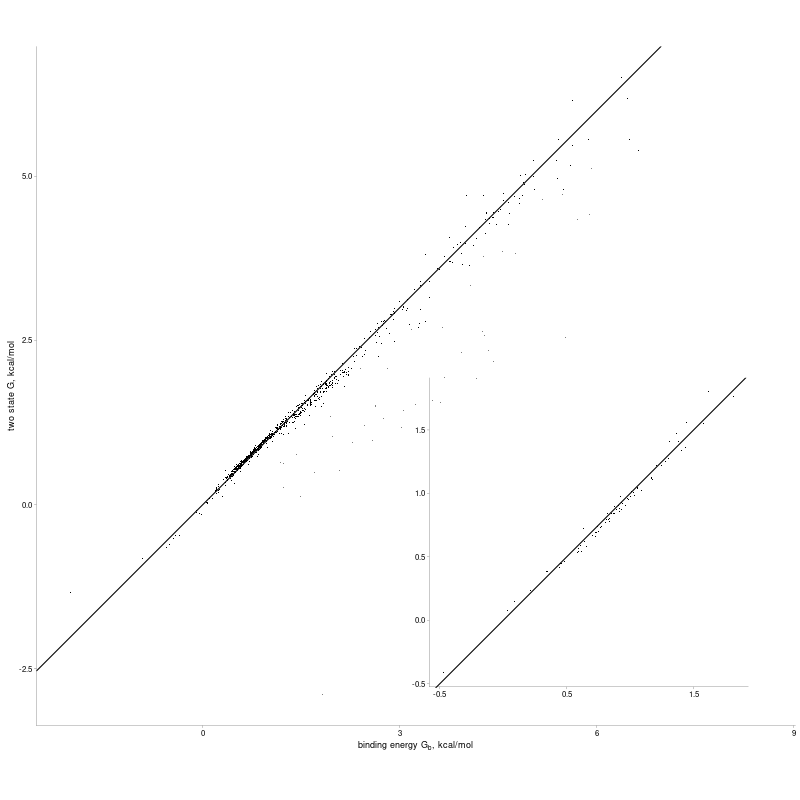

RCall.RObject{RCall.VecSxp}


In [167]:
i = find(data[:ham].==1)
j = map(i -> find(view(data[:x], i, :))[2], i)
pdf = DataFrame(pos = data[:pos][j], aa = data[:aa][j],
        p = max.(m2[:pb0],data[:c1][i]./data[:c0][i]/m2[:r]),
        ef = m2[:pred][:ef][i]* 0.001987 * (273+24), eb = m2[:pred][:eb][i]* 0.001987 * (273+24))
pdf = pdf[pdf[:p].>m2[:pb0],:]
pdf[:gbi] = 0.001987 * (273+24)*(log.(1-pdf[:p]).-log.(pdf[:p]-m2[:pb0]))
display(cor(pdf[:gbi],pdf[:eb]))
R"""
plot.ddgb1 = qplot(data=$pdf ,
    x=gbi, y=eb, color=factor(ef>0), stroke=I(0), size=I(0.5)) + scale_colour_manual(values = c("black", "grey50")) +
xlab(expression(paste("binding energy ", G[b], ", kcal/mol"))) +
ylab("two state G, kcal/mol") +
coord_fixed() + geom_abline() + guides(color=FALSE) +
annotation_custom(grob =  ggplotGrob(plot.ddgb2), xmin = 2.5, xmax = 9, ymin = -3, ymax = 2)
"""

In [168]:
R"""
plot.1 = plot_grid( plot.ddg, plot.ddgb1, labels="AUTO", label_size=11, nrow=2, 
    rel_heights=c(1.3,1))
save_plot("../prediction.pdf", plot.1, base_width=3.25, base_height=6)
"""


RCall.RObject{RCall.NilSxp}
NULL


### residue depth
http://cospi.iiserpune.ac.in/depth/htdocs/intro.html

# A tibble: 2 x 2
  key       c
  <chr> <dbl>
1 ebi   0.270
2 efi   0.805


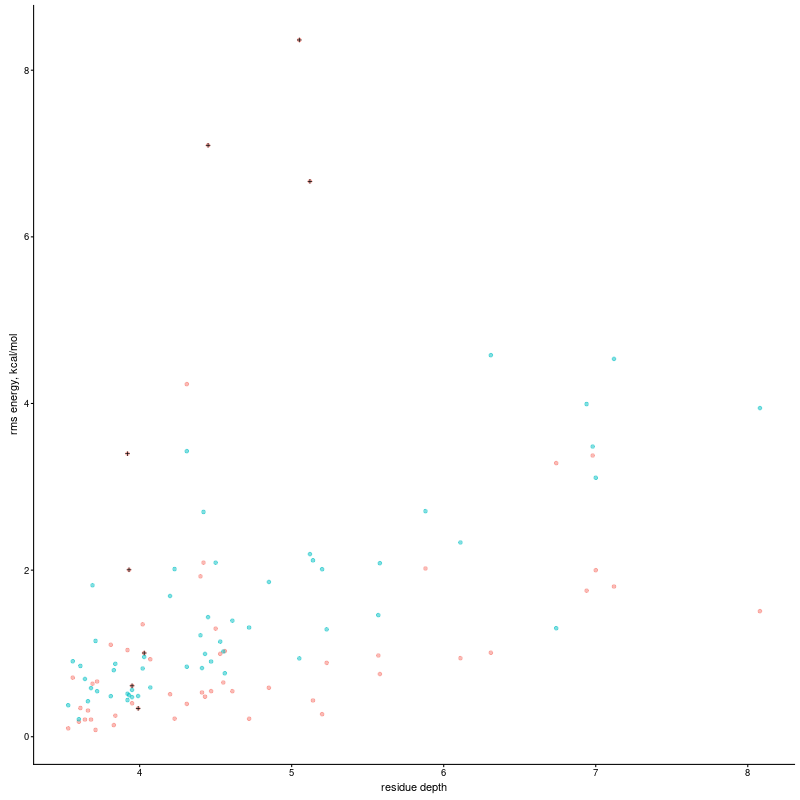

RCall.RObject{RCall.VecSxp}


In [94]:
depth = CSV.read("1PGA.pdb-residue.depth", delim='\t', datarow=2, header=false)
depth[:pos] = [parse(s[3:end]) for s in depth[:Column1]]
#depth = join(depth, m2e, on=:pos)
# display(cor(depth[:all_atom], depth[:x1]))
R"""
library(tidyr)
m2e = $(m2[:energies]) %>% gather("key", "value", efi, ebi) %>%
    mutate(value = value* 0.001987 * (273+24)) %>%
    group_by(pos, key) %>% summarize(rms = sqrt(mean(value^2))) %>%
    inner_join($depth, by="pos") %>% 
    mutate(bindsite=(key=="ebi")&((pos==27)|(pos==28)|(pos==31)|(pos==32)|(pos==35)|(pos==40)|(pos==42)|(pos==43)))
print(m2e %>% group_by(key) %>% summarize(c=cor(rms, Column3)))
plot.depth = qplot(data=m2e, x=Column3, y=rms, color=key, alpha=I(0.5),
    ylab = "rms energy, kcal/mol", xlab="residue depth") + 
    geom_point(data=m2e %>% filter(bindsite), color="black", size=1, shape=3) +
    guides(color=FALSE)
"""

In [97]:
R"m2e %>% arrange(-rms)"

RCall.RObject{RCall.VecSxp}
# A tibble: 110 x 16
# Groups:   pos [55]
     pos key     rms Column1 Column2 Column3 Column4 Column5 Column6 Column7
   <int> <chr> <dbl> <chr>   <fct>     <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1    27 ebi    8.36 A:27    GLU        5.05    1.19    6.13   0.55     4.18
 2    31 ebi    7.10 A:31    LYS        4.45    0.89    5.32   0.45     3.74
 3    43 ebi    6.67 A:43    TRP        5.12    1.3     4      0.49     5.57
 4     3 efi    4.58 A:3     TYR        6.31    0.79    5.56   0.11     6.69
 5    26 efi    4.54 A:26    ALA        7.12    0.49    6.95   0.39     7.79
 6    41 ebi    4.23 A:41    GLY        4.31    0.46    4.31   0.46   NaN   
 7    30 efi    3.99 A:30    PHE        6.94    0.75    6.62   0.290    7.13
 8     5 efi    3.94 A:5     LEU        8.08    0.71    7.5    0.42     8.66
 9    52 efi    3.48 A:52    PHE        6.98    0.7     7.01   0.19     6.97
10    41 efi    3.43 A:41    GLY        4.31    0.46    4.31   0.46   NaN   
# ... 

In [279]:
R"""
save_plot("../depth.pdf", plot.depth, base_aspect_ratio = 1, base_height=4)
"""

RCall.RObject{RCall.NilSxp}
NULL


### substitution matrix

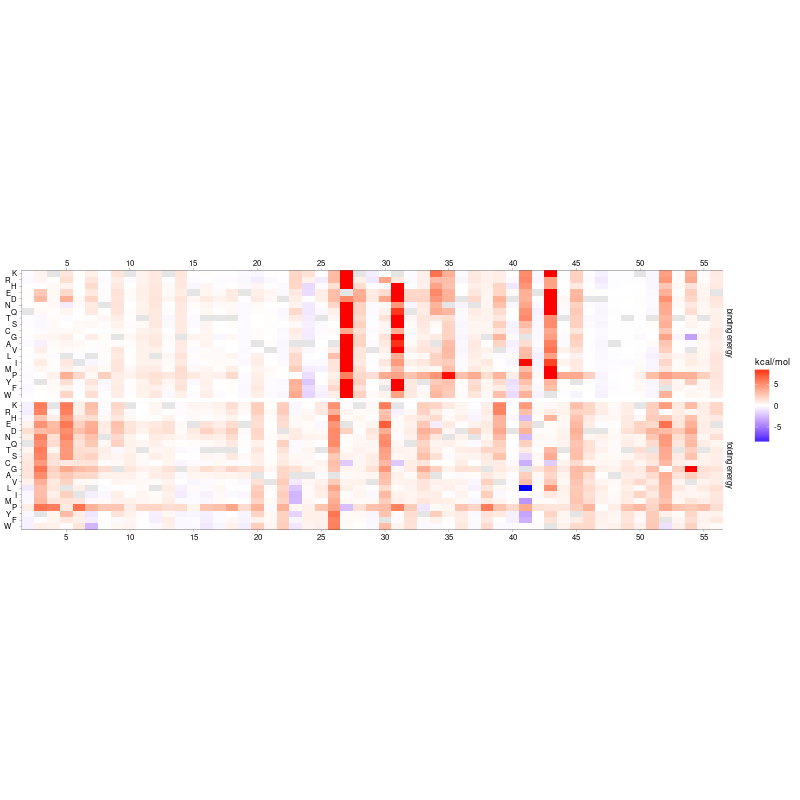

RCall.RObject{RCall.VecSxp}


In [177]:
aalev = reverse(["K", "R", "H", "E", "D", "N","Q","T","S","C","G","A","V","L","I","M","P", "Y", "F", "W"])

R"""

library(tidyr)
d <- $(m2[:energies]) %>% 
    filter(pos>0) %>% rename(`folding energy`=efi, `binding energy` = ebi) %>%
    gather("variable", "value", `folding energy`, `binding energy`) %>%
    mutate(value = value* 0.001987 * (273+24))

library(forcats)
d$aa = factor(d$aa, 
    levels=c("K","R","H","E","D","N","Q","T","S","C","G","A","V","L","I","M","P", "Y", "F", "W"))
d$aa = fct_rev(d$aa)
d$aa = fct_recode(d$aa, `R   `="R", `E   `="E", `N   `="N", `T   `="T", `C   `="C", `A   `="A", `L   `="L", `M   `="M", `Y   `="Y", `W   `="W")

plot.submatrix = ggplot(data=d, 
    aes(x=pos, y=aa, fill=value, color=NULL)) + 
geom_tile() + facet_grid(variable~.) +
scale_fill_gradient2(high="red", low="blue") +
#geom_tile(aes(color=wt)) + scale_color_manual(values = c(alpha("white", 0), "grey80"), guide="none") +
coord_fixed(expand=FALSE, ratio=.5) +
scale_x_continuous(breaks=seq(5, 55, 5), sec.axis = dup_axis()) +
ylab("amino acid") +
xlab("position") +
labs(fill = "kcal/mol") +
#annotate("tile", x=27, y=10.5, width=1, height=20, color="black", fill=NA) +
#annotate("point", x=rep(c(27,28,31,32,35,40,42,43),each=20), y=rep($aalev,8), shape=4, size=5, alpha=.2) +
#geom_point(aes(shape=bs, alpha=bs)) +
theme(panel.grid = element_blank(), strip.background = element_blank(),
    panel.background = element_rect(fill = "grey90", color="grey90"), axis.title = element_blank())
"""

In [190]:
R"""
save_plot("../submatrix.pdf", plot.submatrix, base_width=6.75, base_height=2.5)
"""

RCall.RObject{RCall.NilSxp}
NULL


In [34]:
R"""
cor.test($(m2[:energies][:ebi]),$(m2[:energies][:efi]))
"""

RCall.RObject{RCall.VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$`((m2[:energies])[:ebi])` and `#JL`$`((m2[:energies])[:efi])`
t = 1.081, df = 1044, p-value = 0.2799
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02723104  0.09386199
sample estimates:
       cor 
0.03343819 



### eb ef single muts

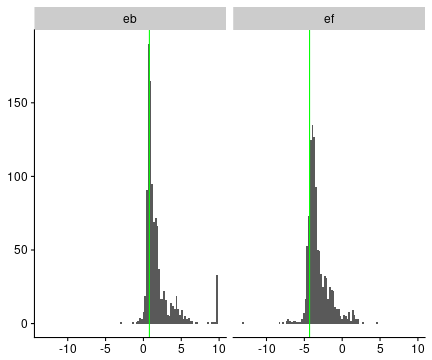

RCall.RObject{RCall.VecSxp}


In [83]:
R"""
library(tidyr)
efeb2 = efeb %>% filter(ham==1) %>% select(ef, eb) %>% gather("key", "value", ef, eb)
plot.inset = ggplot(efeb2, aes(x=value)) +
    geom_histogram(bins=100) + facet_grid(.~key) + labs(x=NULL, y=NULL) +
    geom_vline(aes(xintercept=value), color="green",
        data=data_frame(key=c("ef","eb"), value=c(efeb$ef[1], efeb$eb[1])))
"""

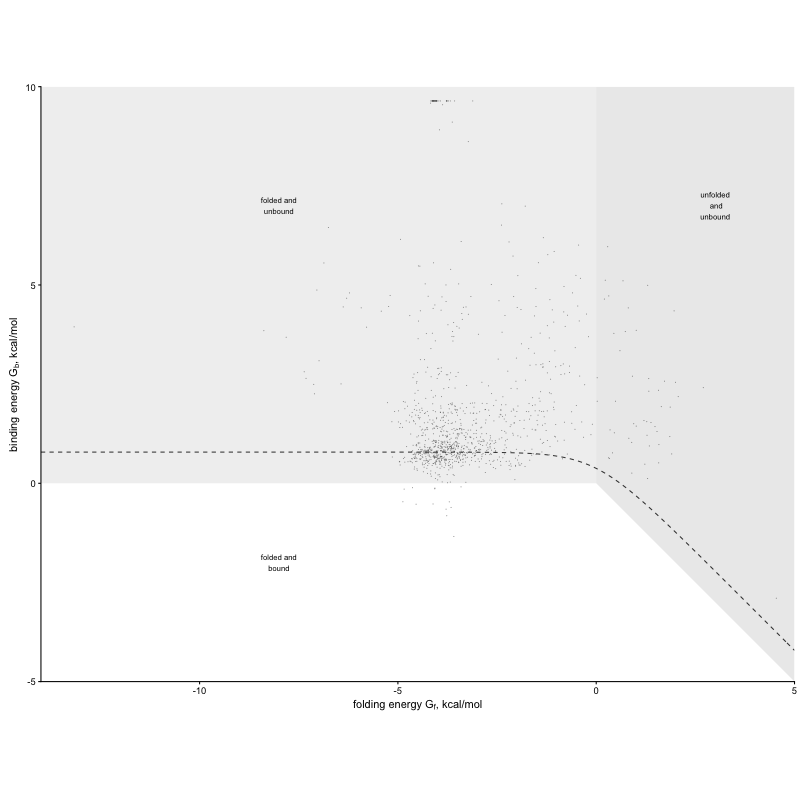

RCall.RObject{RCall.VecSxp}


In [18]:
R"""
library(dplyr)
ef0 = -2
eb0 = -3
ef1 = 1
ef2 = 5
eb1 = 4
eb2 = 3
pwt = $(m2[:pred][:p][1])
efeb = $(m2[:pred]) %>% 
    mutate(ef = ef* 0.001987 * (273+24), eb = eb* 0.001987 * (273+24), ham = $(data[:ham]))
plot.esingle = qplot(data=efeb %>% filter(ham==1), 
    x=ef, y=eb, geom="point", alpha=I(0.5), stroke=I(0), size=I(.5)) +
    coord_fixed(expand=FALSE) +
    geom_point(data=efeb %>% filter(ham==0), color="gray70", alpha=0.8) +
    stat_function(fun = function(ef) (log(1/pwt-1)-log(1+exp(ef/(0.001987*(273+24)))))* 0.001987 * (273+24), 
       color="black", alpha=0.8, linetype=2) +
    annotate("text", x=-8, y=-2, label="folded and\nbound", size=2.7) +
    annotate("text", x=3, y=7, label="unfolded\n and\nunbound", size=2.7) +
    annotate("text", x=-8, y=7, label="folded and\nunbound", size=2.7) +
    labs(x=expression(paste("folding energy ", G[f], ", kcal/mol")), 
         y=expression(paste("binding energy ", G[b], ", kcal/mol")), fill="count") +
    geom_polygon(data=data_frame(ef=c(0, 5, 5, 0, 0), eb=c(10, 10, -5, 0, 10)), fill="grey10", alpha=0.1) +
    geom_polygon(data=data_frame(ef=c(-14, 0, 0, -14), eb=c(10, 10, 0, 0)), fill="grey40", alpha=0.1)
    
"""

### eb ef double muts

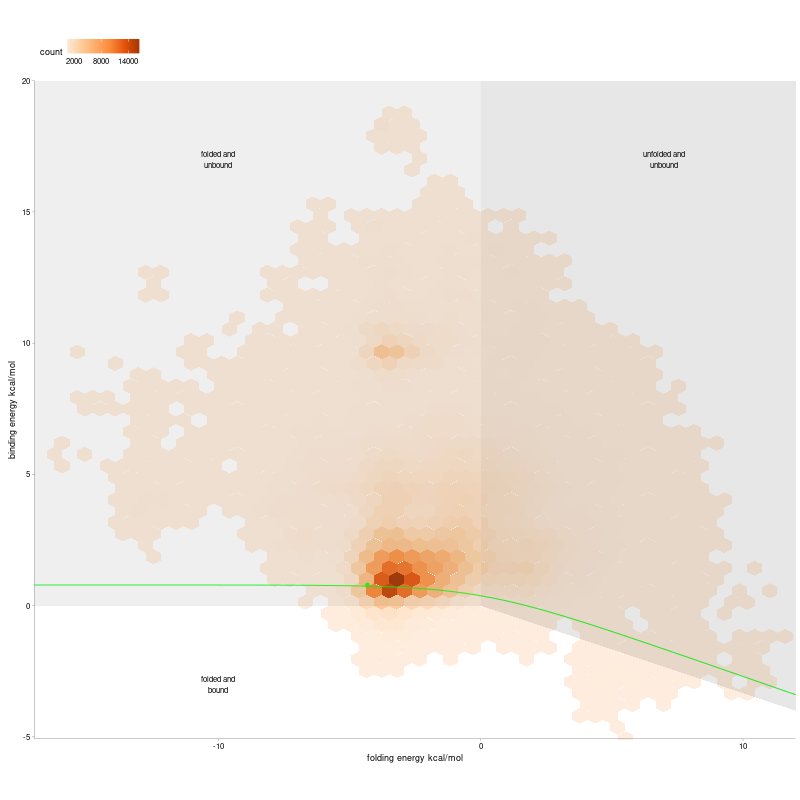

RCall.RObject{RCall.VecSxp}


In [223]:
R"""
plot.edouble = ggplot(data=efeb %>% filter(ham==2),
    aes(x=ef, y=eb)) + geom_hex(bins=50, aes(color=NULL)) +
coord_fixed(expand=FALSE) +
geom_point(data=efeb %>% filter(ham==0), color="green", alpha=0.8) +
    stat_function(fun = function(ef) (log(1/pwt-1)-log(1+exp(ef* 0.001987 * (273+24))))* 0.001987 * (273+24), 
   color="green", alpha=0.8) +
    geom_polygon(data=data_frame(ef=c(0, 12, 12, 0, 0), eb=c(20, 20, -4, 0, 20)), fill="grey10", alpha=0.1) +
    geom_polygon(data=data_frame(ef=c(-17, 0, 0, -17), eb=c(20, 20, 0, 0)), fill="grey40", alpha=0.1) +
annotate("text", x=-10, y=-3, label="folded and\nbound", size=2.7) +
annotate("text", x=7, y=17, label="unfolded and\nunbound", size=2.7) +
annotate("text", x=-10, y=17, label="folded and\nunbound", size=2.7) +
labs(x=expression(paste("folding energy kcal/mol")), 
     y=expression(paste("binding energy kcal/mol")), fill="count") +
scale_fill_distiller(palette=7, direction=1, breaks=c(2000, 8000,14000)) +
    theme(legend.position="top")
"""

In [224]:
R"""
save_plot("../doubles.pdf", plot.edouble, base_width=3.25, base_height=)
"""

RCall.RObject{RCall.NilSxp}
NULL


### epistasis

In [179]:
function doublemuts(m, m1)
    data = m[:data]
    aa = data[:aa]
    pos = data[:pos]
    f = data[:f]
    x = data[:x]
    xij = zeros(pos)
    fhat1 = m1[:pred][:f]
    fhat2 = m[:pred][:f]
    fv = data[:fv]
    ham = data[:ham]
    for i in find(ham .== 1)
        j = find(view(x,i,:))[2]
        xij[j] = i
    end
    process(i) = begin
        nz = find(view(x,i,:))
        i1 = xij[nz[2]]
        i2 = xij[nz[3]]
        d = DataFrame(aa1 = aa[nz[2]], aa2 = aa[nz[3]], 
            pos1 = pos[nz[2]], pos2 = pos[nz[3]],
            fmin = min(f[i1], f[i2], f[i]), 
            fhatmin1 = min(fhat1[i1], fhat1[i2], fhat1[i]),
            fhatmin2 = min(fhat2[i1], fhat2[i2], fhat2[i]),
            epi = f[i] - f[i1] - f[i2], 
            epihat1 = fhat1[i] - fhat1[i1] - fhat1[i2],
            epihat2 = fhat2[i] - fhat2[i1] - fhat2[i2],
            epiv = fv[i] + fv[i1] + fv[i2]
            )
        if d[:pos1][1] > d[:pos2][1]
            d[:aa1], d[:aa2] = d[:aa2], d[:aa1]
            d[:pos1], d[:pos2] = d[:pos2], d[:pos1]
        end
        return d
    end
    return mapreduce(process, vcat, find(ham .== 2))
end
dbls = doublemuts(m2, m1)

,aa1,aa2,pos1,pos2,fmin,fhatmin1,fhatmin2,epi,epihat1,epihat2,epiv
1,A,A,2,3,-2.19199,-1.18364,-2.04369,-2.06224,0.0510292,-1.61791,0.0357927
2,A,C,2,3,-1.32506,-1.13571,-1.76926,-1.25829,0.0499759,-1.40813,0.172196
3,A,D,2,3,-4.65115,-4.91997,-4.87081,0.405555,-0.0375016,-0.363031,0.42047
4,A,E,2,3,-4.72415,-5.11559,-5.40028,-0.118658,-0.0640244,-0.811932,0.688913
5,A,F,2,3,0.0528215,-0.0802548,-0.0833198,-0.131899,0.00566931,0.00692346,0.0205406
6,A,G,2,3,-4.82865,-3.91243,-4.72397,-1.86675,0.0358534,-1.48691,0.677856
7,A,H,2,3,0.109038,-0.186671,-8.77244e-5,-0.448775,0.012546,-0.238127,0.0314544
8,A,I,2,3,-1.4287,-1.63819,-1.52697,-0.600102,0.0583182,-0.378839,0.0289407
9,A,K,2,3,-4.05249,-3.67099,-4.51121,-1.51328,0.0442197,-1.54229,0.295395
10,A,L,2,3,-1.70301,-0.616552,-0.46595,-1.8857,0.0340485,-0.346501,0.0166776


#### all

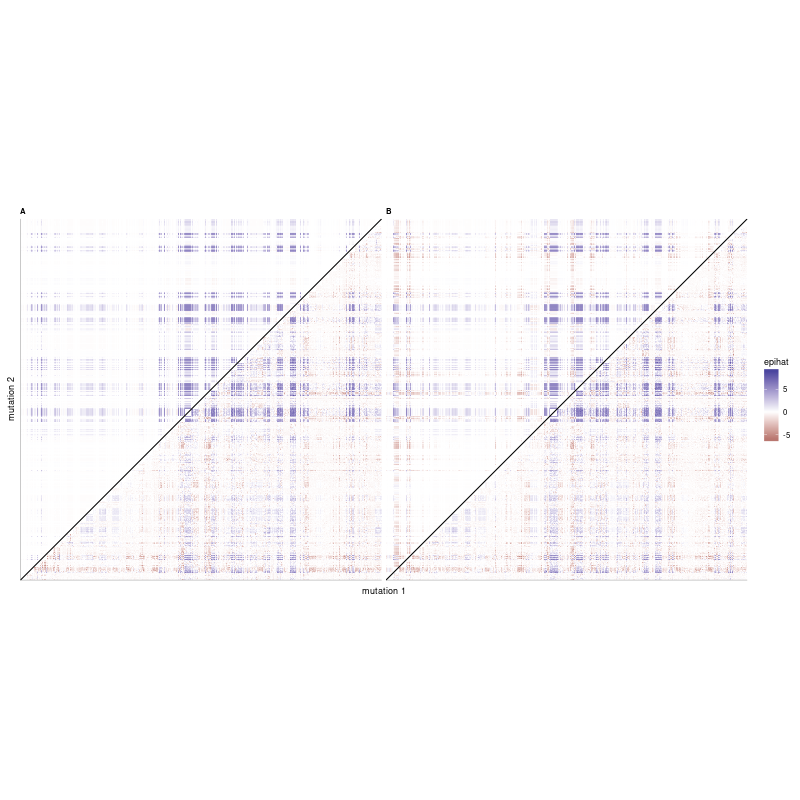

RCall.RObject{RCall.VecSxp}


In [181]:
R"""
library(tidyr)
dbls2 = $dbls %>%
    rename(A=epihat1, B=epihat2) %>%
    gather("model", "epihat", A, B) %>% 
    mutate(n1 = sprintf("%02i:%s", pos1, aa1),
        n2 = sprintf("%02i:%s", pos2, aa2))
qplot(data=dbls2, x=n1, y=n2, fill=epihat, facets=.~model, geom="raster") + 
    geom_raster(aes(x=n2,y=n1,fill=epi)) +
    labs(x="mutation 1", y="mutation 2") +
    scale_fill_gradient2() + coord_fixed() + geom_abline() +
    theme(axis.text=element_blank(), axis.ticks=element_blank(), 
        strip.background=element_blank(), strip.text = element_text(face="bold", hjust=0))
"""

#### filtered fmin > -4.5

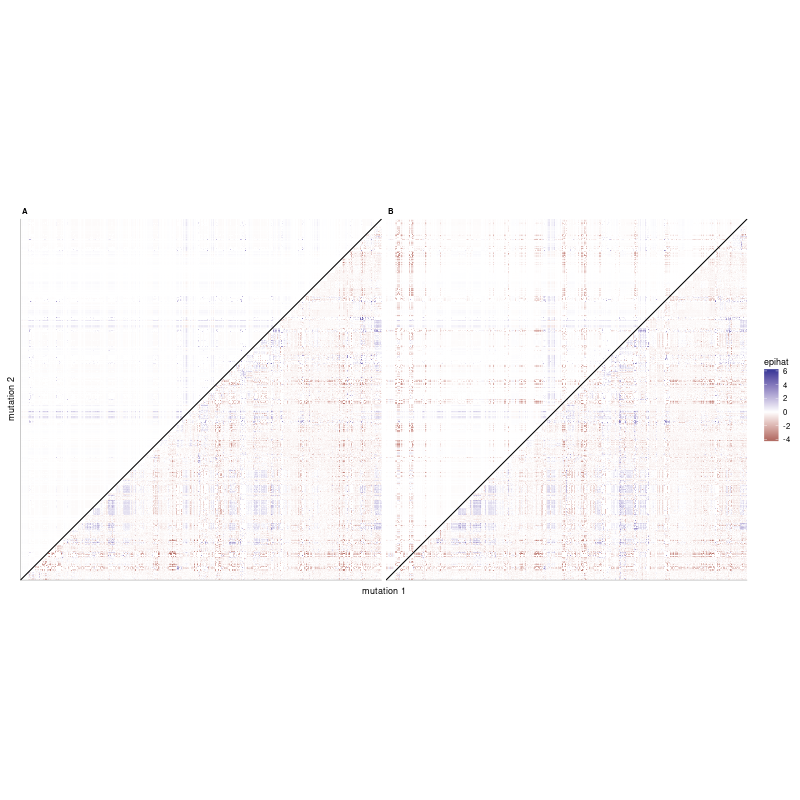

RCall.RObject{RCall.VecSxp}


In [182]:
R"""
dbls3 = dbls2 %>% filter(fmin > -4.5)
plot.epi = qplot(data= dbls3, 
    x=n1, y=n2, fill=epihat, facets=.~model,geom="raster") + 
    geom_raster(aes(x=n2,y=n1,fill=epi)) +
    labs(x="mutation 1", y="mutation 2") +
    scale_fill_gradient2() + coord_fixed() + geom_abline() +
    theme(axis.text=element_blank(), axis.ticks=element_blank(), 
        strip.background=element_blank(), strip.text = element_text(face="bold", hjust=0.005))
"""

In [244]:
R"""
save_plot("../epifull.png", plot.epi, base_width=6.75, base_height=3.4)
""" 

RCall.RObject{RCall.NilSxp}
NULL


#### averaged

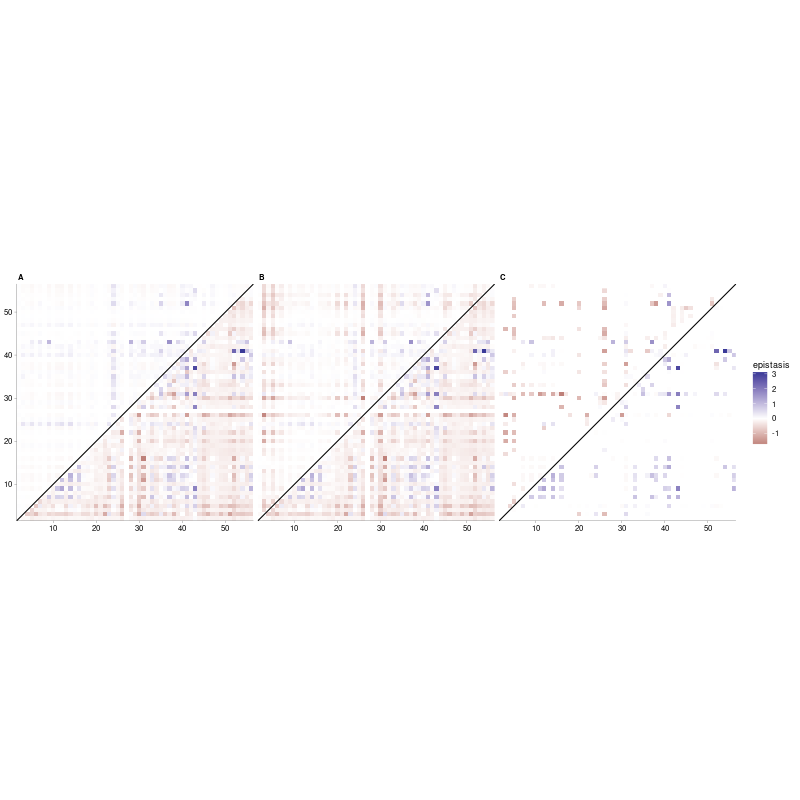

RCall.RObject{RCall.VecSxp}


In [183]:
R"""
dblsm = dbls3 %>%
    group_by(pos1, pos2, model) %>% 
    summarize(epihat = sum(epihat/sqrt(epiv))/sum(1/sqrt(epiv)),
            epi = sum(epi/sqrt(epiv))/sum(1/sqrt(epiv)),
            epiv = mean(epiv)) %>% ungroup %>%
    mutate(z = (epihat-epi)/sqrt(epiv))

dblsm = dblsm %>% filter(z < quantile(z, 0.05)) %>%
    bind_rows(dblsm %>% filter(z > quantile(z, 0.95)) %>% 
    rename(pos1=pos2,pos2=pos1)) %>%
    select(-z) %>% mutate(model="C") %>%
    bind_rows(dblsm)

plot.episum = qplot(data= dblsm, x=pos1, y=pos2, fill=epihat, geom="raster", 
    facets=.~model) +
    geom_raster(aes(x=pos2,y=pos1,fill=epi)) +
    scale_fill_gradient2() + geom_abline() +
    labs(fill="epistasis", x= NULL, y=NULL) +
    coord_fixed(expand=FALSE) + 
    theme(strip.background=element_blank(), strip.text = element_text(face="bold", hjust=0.005))


"""

In [188]:
R"""
save_plot("../epi.pdf", plot.episum, base_width=6.75, base_height=2.4)
""" 

RCall.RObject{RCall.NilSxp}
NULL


#### statistics

In [205]:
R"dbls3 %>% group_by(model) %>% 
    summarize(accuracy1 = mean(epi*epihat>0),
              c = cor(epi,epihat))"

RCall.RObject{RCall.VecSxp}
# A tibble: 2 x 3
  model accuracy1     c
  <chr>     <dbl> <dbl>
1 A         0.554 0.330
2 B         0.630 0.561


In [206]:
R"dblsm %>% group_by(model) %>%     
    summarize(accuracy1 = mean(epi*epihat>0),
              c = cor(epi,epihat))"

RCall.RObject{RCall.VecSxp}
# A tibble: 3 x 3
  model accuracy1     c
  <chr>     <dbl> <dbl>
1 A         0.543 0.499
2 B         0.727 0.660
3 C         0.514 0.498


### bootstrap parameters

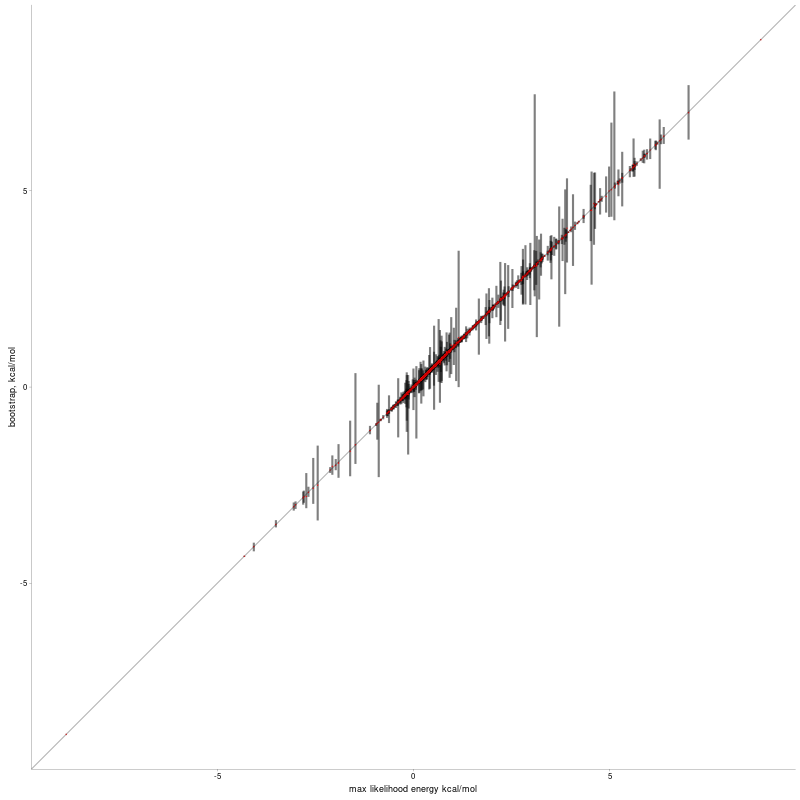

RCall.RObject{RCall.VecSxp}


In [236]:
R"""
plot.boot.f = qplot(data=$(m2[:energies_boot]) %>%
     mutate_if(is.numeric, funs(. * 0.001987 * (273+24))),
    x=efi, y=f_med, ymin = f_lower, ymax=f_upper, 
    size=I(1), alpha=I(0.5),
    geom="linerange", xlab="max likelihood energy kcal/mol", ylab="bootstrap, kcal/mol") +
    geom_point(size=0.2, color="red", alpha=0.5) + geom_abline(alpha=0.3) + coord_fixed()

"""

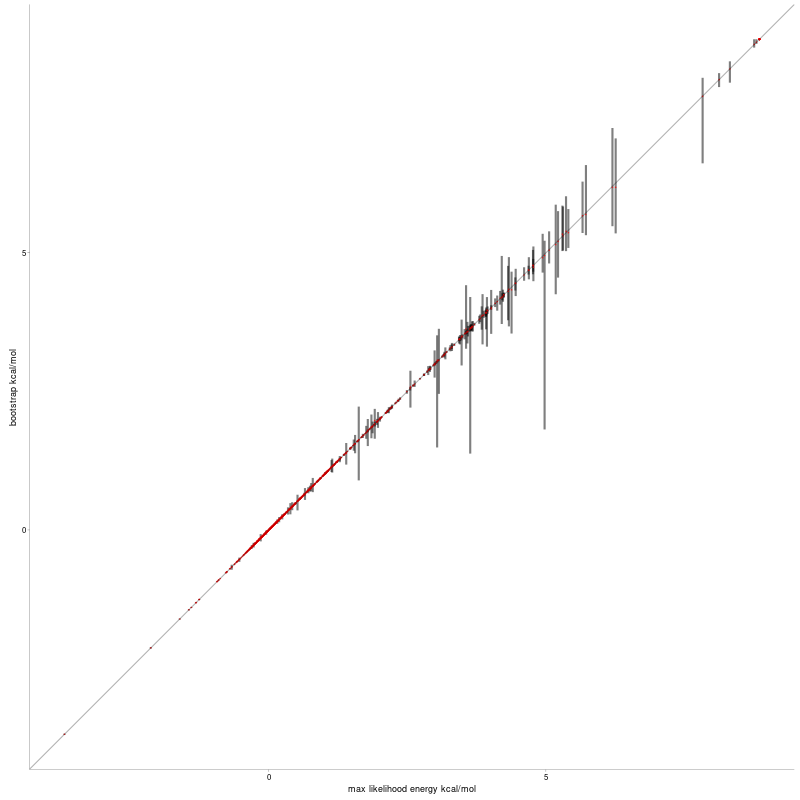

RCall.RObject{RCall.VecSxp}


In [237]:
R"""
plot.boot.b = qplot(data=$(m2[:energies_boot]) %>%
         mutate_if(is.numeric, funs(. * 0.001987 * (273+24))),
    x=ebi, y=b_med, ymin = b_lower, ymax=b_upper, 
    size=I(1), alpha=I(0.5),
    geom="linerange", xlab="max likelihood energy kcal/mol", ylab="bootstrap kcal/mol") +
    geom_point(size=0.2, color="red", alpha=0.5) + geom_abline(alpha=0.3) + coord_fixed()
"""

In [242]:
R"""
plot.boot = plot_grid( plot.boot.f, plot.boot.b,
 ncol=2, labels="AUTO")
save_plot("../boot.pdf", plot.boot, base_width=6.75, base_height=3.35)
"""

RCall.RObject{RCall.NilSxp}
NULL


## Wu 4 site data

In [88]:
using DataFrames
using CSV
d4 = CSV.read("wu4sites.txt", delim="\t")
delete!(d4, [:I10fit, :I20fit, :I20fitRaw, :I90fit, :AOfit,:IGG10,:IGG90])
d4 = d4[.!contains.(d4[:mut], "_") ,:]
d4[:Input] = d4[:Input] + .5
d4[:IGG20] = d4[:IGG20] + .5
d4[:f] = log.(d4[:IGG20]./d4[:Input])#*d[:Input][1]/338347)
d4[:f] = d4[:f] - d4[:f][d4[:HD].==0][1]
d4[:v] = 1./d4[:IGG20].+1./d4[:Input]
d4[:v][d4[:HD].!=0] += d4[:v][d4[:HD].==0][1]
sort!(d4, :Input, rev = true)

,mut,HD,Input,IGG20,f,v
1,VDGV,0,92735.5,3.38347e5,0.0,1.37389e-5
2,WVRL,4,19450.5,713.5,-4.59976,0.00146669
3,RVRS,4,18836.5,196.5,-5.85721,0.00515589
4,RVLS,4,18450.5,455.5,-4.99577,0.00226333
5,RVGL,3,18395.5,55169.5,-0.196015,8.6226e-5
6,WVVL,4,18301.5,369.5,-5.19691,0.00277474
7,WVGL,3,18046.5,42329.5,-0.441787,9.27755e-5
8,WVRS,4,17783.5,1004.5,-4.1681,0.00106549
9,RVLP,4,17630.5,291.5,-5.39666,0.00350099
10,WVVS,4,17601.5,391.5,-5.10007,0.00262483


In [65]:
by(d4, :HD, d -> mean(d[:v]))

,HD,x1
1,0,1.37389e-5
2,4,0.712344
3,3,0.557449
4,2,0.425979
5,1,0.242754


In [89]:
function predict4(m, seq, wt, pos)
    data = m[:data]
    code = data[:code]
    n = length(seq)
    I = collect(Int64, 1:n)
    J = ones(Int64, n)
    for (i,p) in zip(1:length(pos), pos), (is,s) in enumerate(seq)
        if s[i] != wt[i]
            j = code[Symbol("P$p")][string(s[i])]
            push!(I, is)
            push!(J, j)
        end
    end
    x = sparse(I, J, 1.0, n, size(data[:x],2))
    predict(m, x)
end
wu4pred = predict4(m2, d4[:mut], "VDGV", [39, 40, 41, 54])

,ef,eb,p,f
1,-7.30569,1.33516,0.208755,0.0
2,-2.14642,15.9725,0.000706718,-5.68829
3,11.5814,12.0168,0.000706615,-5.68843
4,-8.46595,8.20695,0.000979042,-5.36234
5,2.57601,3.27158,0.00338029,-4.1232
6,-2.28383,11.8951,0.000712803,-5.67971
7,-7.19378,6.8146,0.00180144,-4.75257
8,1.81162,15.5599,0.000706639,-5.6884
9,-9.10226,13.3522,0.000708203,-5.68619
10,1.67421,11.4825,0.000708241,-5.68613


### f fhat plot

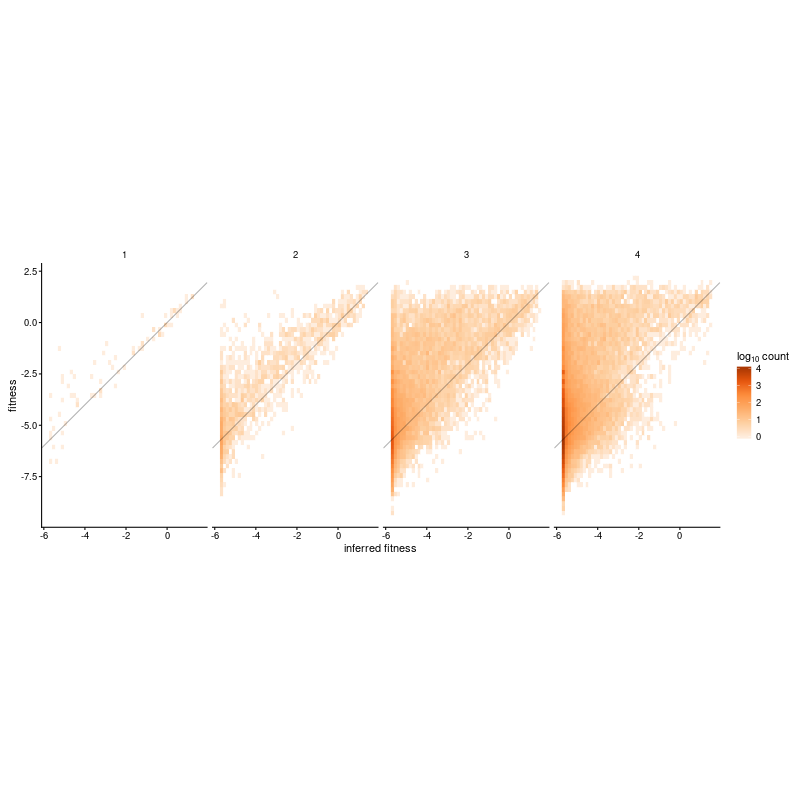

RCall.RObject{RCall.VecSxp}


In [91]:
wu4pred[:fn] = d4[:f]
wu4pred[:ham] = d4[:HD]
R"""
leglab = expression(paste(log[10], " count"))
plot.wu1 = ggplot(data=$wu4pred[-1,], aes(x=f, y=fn)) + 
    geom_bin2d(bins=50,aes( fill=log10(..count..), color=log10(..count..))) + 
    facet_wrap(~ham, ncol=4) + 
    geom_abline(alpha=0.3, color="black") + coord_fixed() +
    labs(x="inferred fitness", y="fitness", fill=leglab, color=leglab) +
    scale_fill_distiller(palette=7, direction=1)+
    scale_color_distiller(palette=7, direction=1) + theme(strip.background=element_blank())

"""

In [199]:

R"""
save_plot("../wu1.pdf", plot.wu1, base_width=6.75, base_height=2.5)
"""

RCall.RObject{RCall.NilSxp}
NULL


### cdf plot

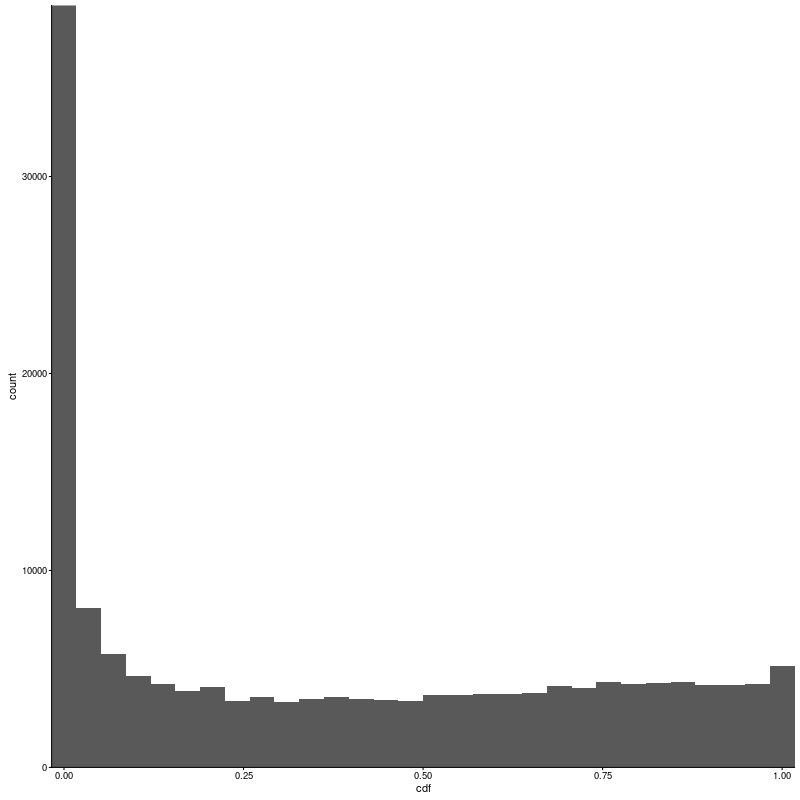

RCall.RObject{RCall.VecSxp}


In [92]:
wu4pred[:ham] = d4[:HD]
wu4pred[:z] = (wu4pred[:f].-d4[:f])./sqrt.(d4[:v])
wu4pred[:cdf] = cdf.(Normal(), wu4pred[:z])
R"""
plot.wuz = qplot(data=$wu4pred[-1,], x=cdf, bins=30) +
    coord_cartesian(expand=FALSE)

"""

In [357]:
30000/nrow(wu4pred)

0.20085564504790407

In [245]:
R"""
save_plot("../wuz.pdf", plot.wuz, base_width=3.25, base_height=3.25)
"""

RCall.RObject{RCall.NilSxp}
NULL


### statistics

In [93]:
using StatsBase
wu4pred[:fdead] = wu4pred[:f] .< -2.5
wu4pred[:fndead] = wu4pred[:fn] .< -2.5
wu4pred[:v] = d4[:v]
by(wu4pred[2:end,:], [:ham], d -> DataFrame(c = cor(hcat(d[:f], d[:fn]))[1,2], 
          n = nrow(d),
          msez = sqrt(mean((d[:f]-d[:fn]).^2./d[:v])),
          medz = median(abs.((d[:f]-d[:fn])./sqrt.(d[:v]))),
          TN = sum(d[:fdead] .& d[:fndead]),
          TP = sum(.!d[:fdead] .& .!d[:fndead]),
          FP = sum(.!d[:fdead] .& d[:fndead]),
          FN = sum(d[:fdead] .& .!d[:fndead])))

,ham,c,n,msez,medz,TN,TP,FP,FN
1,4,0.478431,129051,26.5386,1.03863,120135,998,173,7745
2,3,0.688169,27284,35.7426,1.40113,22291,1611,163,3219
3,2,0.859416,2158,24.6381,2.19029,1387,500,20,251
4,1,0.924079,76,7.75192,2.77915,29,39,1,7


In [75]:
173/(120135+173)

0.0014379758619543174

In [73]:
998/(998+7745)

0.11414846162644401

## pedagogical figure

In [3]:
R"theme_set(theme_cowplot(font_size = 9, line_size = 0.1))"

RCall.RObject{RCall.VecSxp}
List of 57
 $ line                 :List of 6
  ..$ colour       : chr "black"
  ..$ size         : num 0.5
  ..$ linetype     : num 1
  ..$ lineend      : chr "butt"
  ..$ arrow        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_line" "element"
 $ rect                 :List of 5
  ..$ fill         : chr "transparent"
  ..$ colour       : logi NA
  ..$ size         : num 0
  ..$ linetype     : num 0
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_rect" "element"
 $ text                 :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       : 'margin' num [1:4] 0pt 0pt 0pt 0pt
  .. ..- attr(*, "valid.unit")= int 8
  .. ..- attr(*, "unit")= chr "pt"
  ..$ debug        : logi FALSE
  .

[1] 0.9464991
[1] 0.2119416
[1] 0.0452785
[1] 0.0003293204


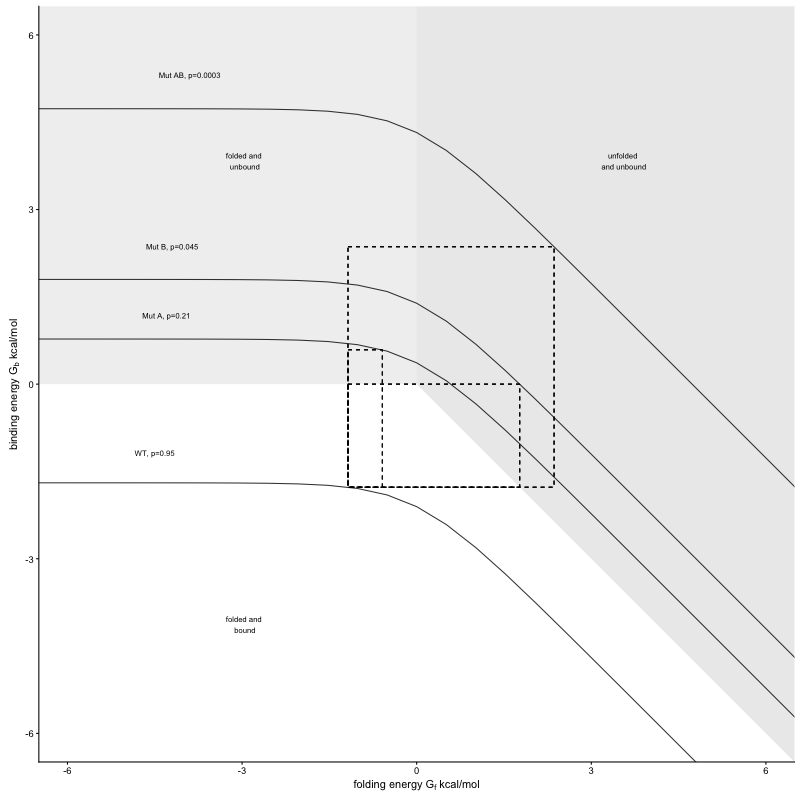

RCall.RObject{RCall.VecSxp}


In [13]:
R"""
ef0 = -2
eb0 = -3
ef1 = 1
ef2 = 5
eb1 = 4
eb2 = 3
RT = 0.001987 * (273+24)
print(1/(1+exp(eb0)*(1+exp(ef0))))
print(1/(1+exp(eb0+eb1)*(1+exp(ef0+ef1))))
print(1/(1+exp(eb0+eb2)*(1+exp(ef0+ef2))))
print(1/(1+exp(eb0+eb1+eb2)*(1+exp(ef0+ef1+ef2))))
plot.ped = ggplot(data=data_frame(ef=c(-15, 0, 15, -15, -15)/RT, eb=c(0, 0, -15, -15, 0)/RT), 
    aes(x=ef, y=eb)) +
    geom_polygon(data=data_frame(ef=c(0, 15, 15, 0, 0)/RT, eb=c(15, 15, -15, 0, 15)/RT), fill="grey10", alpha=0.1) +
    geom_polygon(data=data_frame(ef=c(-15, 0, 0, -15)/RT, eb=c(15, 15, 0, 0)/RT), fill="grey40", alpha=0.1) +
stat_function(fun = function(ef) RT*(eb0+log(1+exp(ef0))-log(1+exp(ef/RT))), 
   color="black", alpha=0.8) +
stat_function(fun = function(ef) RT*(eb0+eb1+log(1+exp(ef0+ef1))-log(1+exp(ef/RT))), 
   color="black", alpha=0.8) +
stat_function(fun = function(ef) RT*(eb0+eb2+log(1+exp(ef0+ef2))-log(1+exp(ef/RT))), 
   color="black", alpha=0.8) +
stat_function(fun = function(ef) RT*(eb0+eb1+eb2+log(1+exp(ef0+ef1+ef2))-log(1+exp(ef/RT))), 
   color="black", alpha=0.8) +
annotate("text", x=-5*RT, y=-7*RT, label="folded and \nbound", size=2.7) +
annotate("text", x=-5*RT, y=6.5*RT, label="folded and \nunbound", size=2.7) +
annotate("text", x=6*RT, y=6.5*RT, label="unfolded\n and unbound", size=2.7) +
annotate("text", x=-4.5, y=-2*RT, label="WT, p=0.95", size=2.7) +
annotate("text", x=-4.3, y=2*RT, label="Mut A, p=0.21", size=2.7) +
annotate("text", x=-4.2, y=4*RT, label="Mut B, p=0.045", size=2.7) +
annotate("text", x=-3.9, y=9*RT, label="Mut AB, p=0.0003", size=2.7) +
labs(x=expression(paste("folding energy ", G[f], " kcal/mol")), y=expression(paste("binding energy ", G[b], " kcal/mol"))) +
geom_rect(aes(xmin=ef0*RT, xmax=(ef0+ef1)*RT, ymin=eb0*RT, ymax=(eb0+eb1)*RT), color="black", fill=NA, linetype=2, alpha=0.3, size=.3) +
geom_rect(aes(xmin=ef0*RT, xmax=(ef0+ef1+ef2)*RT, ymin=eb0*RT, ymax=(eb0+eb1+eb2)*RT), color="black", fill=NA, linetype=2, alpha=0.8, size=.3) +
geom_rect(aes(xmin=ef0*RT, xmax=(ef0+ef2)*RT, ymin=eb0*RT, ymax=(eb0+eb2)*RT), color="black", fill=NA, linetype=2, alpha=0.3, size=.3) +
coord_fixed(xlim=c(-10,10)*RT, ylim=c(-10, 10)*RT) 
"""

In [19]:
R"""
plot.land = plot_grid(plot.ped, plot.esingle, labels="AUTO", nrow=2, label_size=11, 
    rel_heights=c(1.4,1))
save_plot("../landscape.pdf", plot.land, base_width=3.25, base_height=5.8)
"""

RCall.RObject{RCall.NilSxp}
NULL


## validate with artificial data

### test 1

In [50]:
efi = [rand(m2[:energies][:efi][2:end]) for i = 1:size(data[:x],2)]
efi[1] = -7
ebi = [rand(m2[:energies][:ebi][2:end]) for i = 1:size(data[:x],2)]
ebi[1] = 1
pr = 10*(1-0.001)./(1.+exp.(data[:x]*ebi).+exp.(data[:x]*(efi.+ebi)))+10*0.001
data_fake = copy(data)
data_fake[:c0] = rand.(Poisson.(data[:c0]))
data_fake[:c1] = rand.(Poisson.(data[:c0].*pr))

In [51]:
@time mfake = energymodel(data_fake, :fold_and_bind, 15)
mfake = bootsearch(mfake, 100, 1e-4, m ->  display(cor(m[:energies][:efi],efi)))
cor(efi, mfake[:energies][:efi])

370.609716 seconds (76.28 k allocations: 77.077 MiB, 0.01% gc time)


Dict{Symbol,Any} with 9 entries:
  :data     => Dict{Symbol,Any}(Pair{Symbol,Any}(:f, [0.0, 0.777714, -7.88913, …
  :kind     => :fold_and_bind
  :return   => :FTOL_REACHED
  :maxe     => 15
  :pred     => 536963×4 DataFrames.DataFrame…
  :energies => 1046×4 DataFrames.DataFrame…
  :ll       => -4.95036e8
  :pb0      => 0.000100495
  :r        => 96.5087

In [83]:
using JLD
#@save "test1.jld" mfake efi ebi
@load "test1.jld"

3-element Array{Symbol,1}:
 :ebi  
 :efi  
 :mfake

In [84]:
cor(efi, mfake[:energies][:efi])

0.859084912547928

In [85]:
cor(ebi, mfake[:energies][:ebi])

0.9789163554400553

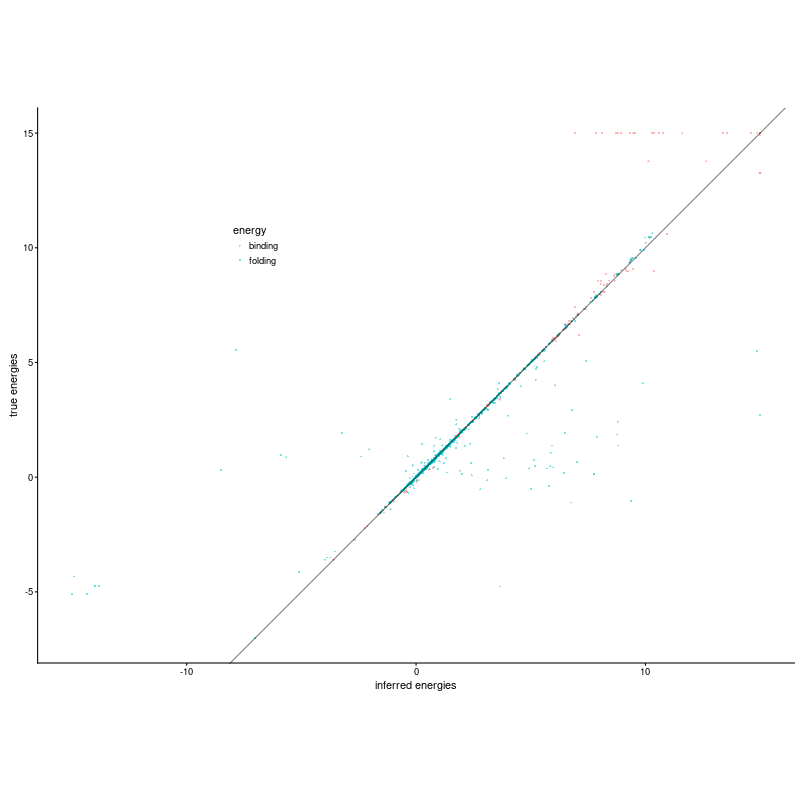

RCall.RObject{RCall.VecSxp}


In [78]:
R"""
d = $(mfake[:energies])
d$efi_true = $efi
d$ebi_true = $ebi
d =d %>% select(-efi_true, -efi) %>% rename(ei = ebi, ei_true=ebi_true) %>% 
    mutate(energy="binding") %>%
    bind_rows(d %>% select(-ebi_true,-ebi) %>% 
        rename(ei = efi, ei_true=efi_true) %>% mutate(energy="folding"))
plot.test1 = qplot(data=d, x=ei, y=ei_true, color=energy, alpha=I(0.5),size=I(1),stroke=0) +
    geom_abline(alpha=0.5) + coord_fixed() + labs(x="inferred energies", y="true energies") +
    theme(legend.position=c(0.25,.75))
"""

### test 2

In [8]:
efi = randn(size(data[:x],2))*5
efi[1] = 0
ebi = randn(size(data[:x],2))*5
ebi[1] = 0
pr = 10*(1-0.001)./(1.+exp.(data[:x]*ebi).+exp.(data[:x]*(efi.+ebi)))+10*0.001
data_fake = copy(data)
c0 = 100000*ones(length(data[:c0]))
#c0 = data[:c0]
using Distributions
data_fake[:c0] = rand.(Poisson.(c0))
data_fake[:c1] = rand.(Poisson.(c0.*pr))
@time mfake1 = energymodel(data_fake, :fold, 15, tol=1e-8)
mfake1[:energies][:ebi] = mfake1[:energies][:efi]
mfake1[:energies][:efi] .= 0
mfake1[:kind] = :fold_and_bind
@time mfake = energymodel(mfake1)

536963-element Array{Int64,1}:
 35
 26
 50
 78
 24
 35
 13
 46
  7
 68
 20
 46
 39
  ⋮
 23
 49
 55
  5
 64
  5
  1
  2
  4
 11
 57
 22

In [79]:
using JLD
#@save "test2.jld" mfake efi ebi
@load "test2.jld"

3-element Array{Symbol,1}:
 :ebi  
 :efi  
 :mfake

In [80]:
cor(efi, mfake[:energies][:efi])

0.9995722403551394

In [81]:
cor(ebi, mfake[:energies][:ebi])

0.9997532690569019

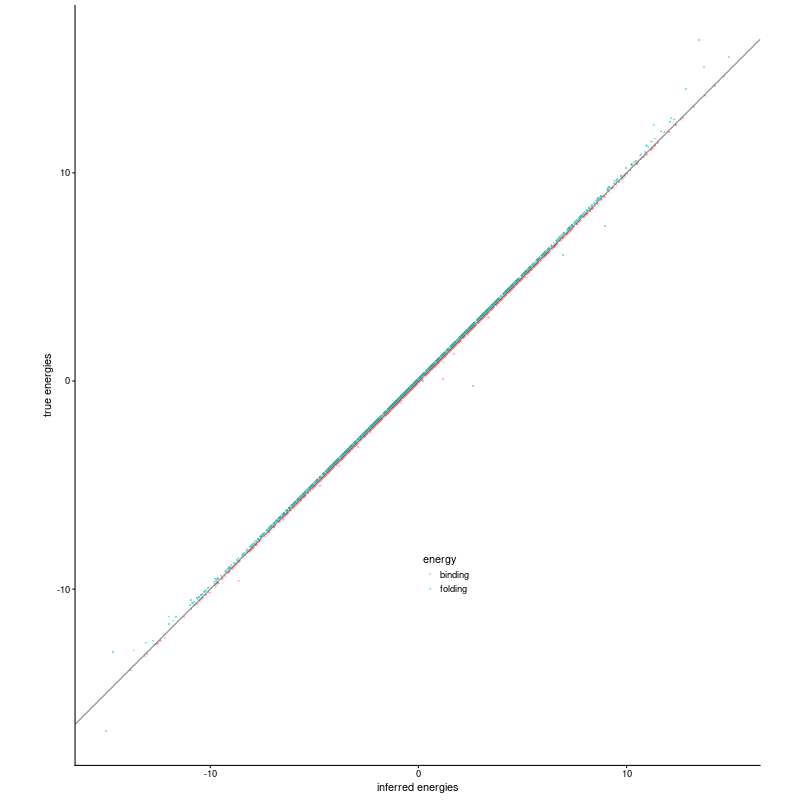

RCall.RObject{RCall.VecSxp}


In [82]:
R"""
d = $(mfake[:energies])
d$efi_true = $efi
d$ebi_true = $ebi
d =d %>% select(-efi_true, -efi) %>% rename(ei = ebi, ei_true=ebi_true) %>% 
    mutate(energy="binding") %>%
    bind_rows(d %>% select(-ebi_true,-ebi) %>% 
        rename(ei = efi, ei_true=efi_true) %>% mutate(energy="folding"))
plot.test2 = qplot(data=d, x=ei, y=ei_true, color=energy, alpha=I(0.5),size=I(1),stroke=0) +
    geom_abline(alpha=0.5) + coord_fixed() + labs(x="inferred energies", y="true energies") +
    theme(legend.position=c(0.5,.25))
"""

In [87]:
R"""
plot.test = plot_grid(plot.test2, plot.test1, labels="AUTO", label_size=11, nrow=1)
save_plot("../test.pdf", plot.test, base_width=6.75, base_height=3)
"""

RCall.RObject{RCall.NilSxp}
NULL
